In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import geom

In [2]:
# load the dataset
df_customers = pd.read_csv('Datasets/marketing_campaign.csv', sep='\t')
df_customers.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

## Pre-Analysis

### Tidying up campaign acceptance columns

In [4]:
# prepare needed columns
main_used_cols = ['ID', 'AcceptedCmp1', 'AcceptedCmp2',
                  'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

df_customers_main = df_customers[main_used_cols]

# assume that 'Response' is whether the customer accepted the 6th campaign offer
df_customers_main.rename(columns={'Response': 'AcceptedCmp6'}, inplace=True)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [5]:
accept_offer_columns = df_customers_main.columns[1:]
df_customers_main['response_sum'] = df_customers_main.loc[:, accept_offer_columns].sum(axis=1)
df_customers_main[df_customers_main['response_sum'] > 1]

/var/folders/0s/2ngs3p4j0dn7m5nk3w1gcrs40000gn/T/ipykernel_3937/287809758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customers_main['response_sum'] = df_customers_main.loc[:, accept_offer_columns].sum(axis=1)


,ID,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp6,response_sum
15,2114,1,0,0,0,1,1,3
39,2968,0,0,1,0,0,1,2
53,2225,1,0,1,0,0,1,3
55,6260,0,0,0,0,1,1,2
60,6853,0,0,0,1,1,1,3
...,...,...,...,...,...,...,...,...
2175,1772,1,0,0,0,1,1,3
2193,8722,1,0,1,0,0,1,3
2194,7118,0,0,1,0,0,1,2
2198,2632,0,0,1,0,0,1,2


There are some customers who accepted multiple campaign offers. We don't know how this could occur, so we will ignore these customers for now.

In [6]:
excluded_customers_idx = df_customers_main[df_customers_main['response_sum'] > 1].index
df_customers_main = df_customers_main.drop(excluded_customers_idx, axis=0).reset_index(drop=True)

In [7]:
# get index of accepting customers and in which campaign
accepting_customers_ix = df_customers_main[accept_offer_columns].to_numpy().nonzero()

# create new column "AcceptedAtNthCampaign"
# default value is -1 (not accepting at all)
df_customers_main['AcceptedAtNthCampaign'] = -1
# fill in for accepting customers
df_customers_main.loc[accepting_customers_ix[0],'AcceptedAtNthCampaign'] = accepting_customers_ix[1] + 1

In [8]:
df_customers_main.query('AcceptedAtNthCampaign > -1')

,ID,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp6,response_sum,AcceptedAtNthCampaign
0,5524,0,0,0,0,0,1,1,6
8,4855,0,0,0,0,0,1,1,6
9,5899,0,0,1,0,0,0,1,3
17,6565,1,0,0,0,0,0,1,1
21,1993,0,0,0,1,0,0,1,4
...,...,...,...,...,...,...,...,...,...
1989,8720,0,0,0,1,0,0,1,4
1991,7004,0,0,1,0,0,0,1,3
1997,4001,1,0,0,0,0,0,1,1
1998,7270,0,0,0,1,0,0,1,4


## Initial Exploration 

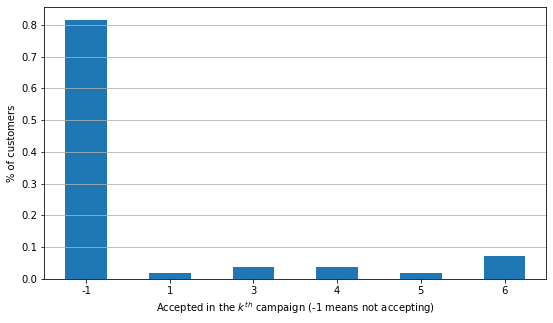

In [19]:
# plot the number of customers who accepted the offer in the nth campaign
accepted_at_pct = df_customers_main['AcceptedAtNthCampaign'].value_counts(normalize=True)

plt.figure(figsize=(9,5))
accepted_at_pct.sort_index().plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel('Accepted in the $k^{th}$ campaign (-1 means not accepting)')
plt.ylabel('% of customers')
plt.grid(axis='y');

In [10]:
p_accepting = 1 - accepted_at_pct[-1]
print('The probability of accepting the campaign offer: {:.2f} percent.'.format(p_accepting * 100))

The probability of accepting the campaign offer: 18.49 percent.


In [11]:
accepted_at_pct

-1    0.815092
 6    0.072964
 3    0.036982
 4    0.036482
 1    0.019490
 5    0.018991
Name: AcceptedAtNthCampaign, dtype: float64

## Modelling Marketing Campaign Acceptance with Geometric Distribution

Suppose that we are running a campaign to offer a certain product to a customer. Each customer can be offered the same product several times up to, let's say, five times, or until he/she accepted the offer. 

From the marketer's perspective, if they send an offer to a customer and then the customer rejects it, it be counted as a "failure". So the marketer can "fail" multiple times before their offer is accepted by a customer, which will be a "success" for them. 

We will model the scenario with Geometric Distribution.

- The probability $p$ for a campaign to be success: 0.1849
- $k$ is the number of failures before the customer accepts the offer

In [12]:
df_geom = pd.DataFrame(columns=['k', 'pmf'])

k_range = range(0, 7)

geom_rv = geom(p_accepting)
for k in k_range:
    # scipy.stats.geom uses k >= 1
    # if k >= 0 is used, k parameter should be added by 1
    k = k + 1
    pmf = geom_rv.pmf(k)
    df_geom = df_geom.append({
        'k': k,
        'pmf': pmf
    }, ignore_index=True)
    
df_geom

,k,pmf
0,1.0,0.184908
1,2.0,0.150717
2,3.0,0.122848
3,4.0,0.100133
4,5.0,0.081617
5,6.0,0.066526
6,7.0,0.054225


In [13]:
# implement pmf with k >= 0
def geometric_pmf(p, k):
    pmf = ((1 - p) ** k) * p
    return pmf

df_geom_alt = pd.DataFrame(columns=['k', 'pmf'])
for k in k_range:
    pmf = geometric_pmf(p_accepting, k)
    df_geom_alt = df_geom_alt.append({
        'k': k,
        'pmf': pmf
    }, ignore_index=True)
df_geom_alt

,k,pmf
0,0.0,0.184908
1,1.0,0.150717
2,2.0,0.122848
3,3.0,0.100133
4,4.0,0.081617
5,5.0,0.066526
6,6.0,0.054225


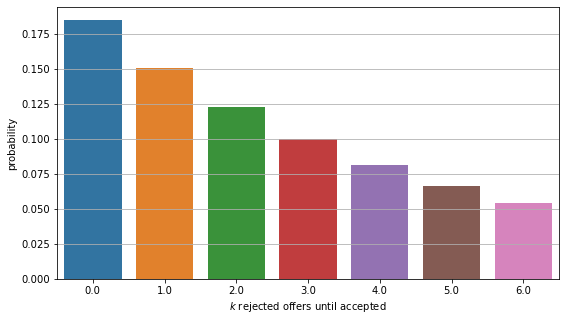

In [33]:
plt.figure(figsize=(9,5))
sns.barplot(x='k', y='pmf', data=df_geom_alt)
plt.xlabel('$k$ rejected offers until accepted')
plt.ylabel('probability')
plt.grid(axis='y');

Assuming that the probability of success is the same on every nth campaign, customer is less likely to accept the campaign after being offered several times.

What could be wrong:

the probability of success is assumed to be the same on every nth campaign, while the actual case can be different (as we saw at the previous barplot). thus, the trials could be not independent to each other (e.g. the chance of accepting may be higher if the customer has refused the offer few times before)

In [15]:
# TODO: calculate the p of success for each trial in nth campaign
# p of accept at nth trial | p of accept = p of accept and at nth trial / p of accept
prob_at_nth_trial = accepted_at_pct.copy()
k_range = range(1, 7)
for k in k_range:
    prob_at_nth_trial[k] = prob_at_nth_trial.get(k, 0) / p_accepting
prob_at_nth_trial.drop(-1, inplace=True)

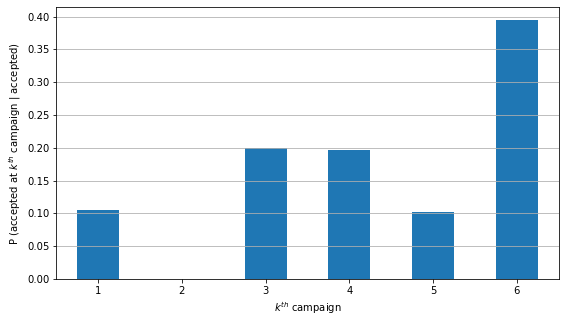

In [36]:
plt.figure(figsize=(9,5))
prob_at_nth_trial.sort_index().plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('P (accepted at $k^{th}$ campaign | accepted)')
plt.xlabel('$k^{th}$ campaign')
plt.grid(axis='y');